* InvoiceNo — unique invoice No
* StockCode — unique product code
* Description — product name
* Quantity — quantity of each item per transaction
* InvoiceDate — Invoice date/time;
* UnitPrice — unit price in pounds sterling
* CustomerID — unique customer ID
* Country — customer residence country.


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [162]:
import sklearn
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"sklearn: {sklearn.__version__}")

pandas: 2.0.1
numpy: 1.24.2
sklearn: 1.2.2


In [163]:
data = pd.read_csv("data/segm_data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceNo': str})
print('Data shape: {}'.format(data.shape))
data.head(3)
#data.info()

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom


In [164]:
print(f"numeric feature qty:")
data.select_dtypes(['int','float']).columns.size

numeric feature qty:


2

In [165]:
data.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [166]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].describe()

count                           541909
mean     2011-07-04 13:34:57.156386048
min                2010-12-01 08:26:00
25%                2011-03-28 11:34:00
50%                2011-07-19 17:17:00
75%                2011-10-19 11:27:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [167]:
display(f"max goods qty: {data['Quantity'].max()} | min goods qty: {data['Quantity'].min()}")
display(f"min prices per unit:")
data['UnitPrice'].sort_values(ascending=True).head(5)

'max goods qty: 80995 | min goods qty: -80995'

'min prices per unit:'

299984   -11062.06
299983   -11062.06
40984         0.00
52217         0.00
52262         0.00
Name: UnitPrice, dtype: float64

In [168]:
data.select_dtypes('object').describe()

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


In [169]:
print(f"nan values: {data.isna().sum().sum(), data.shape}")
print(f"rows with nan in any col: {data.isna().T.any().sum()}")

data = data.dropna(how='any',axis=0)
print(f"nan values: {data.isna().sum().sum(), data.shape}")

nan values: (136534, (541909, 8))
rows with nan in any col: 135080
nan values: (0, (406829, 8))


In [170]:
print(f"duplicates found: {data[data.duplicated()].shape}")
data = data.drop_duplicates().reset_index().drop('index', axis=1)
print(f"DF shape after drop_duplicates: {data.shape}")
data.head(3)

duplicates found: (5225, 8)
DF shape after drop_duplicates: (401604, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


In [171]:
neg_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(neg_quantity.shape[0]))
neg_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [172]:
print(f"Invoices with negative qty but without C-sign (returned):")
neg_quantity['InvoiceNo'].apply(lambda x: 0 if re.search(r"\b\D", x) else 1).sum()

Invoices with negative qty but without C-sign (returned):


0

In [173]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [174]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if re.search(r'\b\D', x) else 0)
(nb_products_per_basket['order_canceled'].value_counts(normalize=True)*100).round(2)

order_canceled
0    83.53
1    16.47
Name: proportion, dtype: float64

if we counted the number of transactions containing a return sign in the original table, where a separate line was created for each unique product, then the number of returns would be less than 1%. 

In [175]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [176]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
37516,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


If for each canceled transaction in the database (data table), there is its analogue with the same product code, customer ID and the opposite value of the product quantity? Seems no

In [177]:
true_cancel = 0
canceled = 0
for i in data.index:
    if 'C' in data.loc[i,'InvoiceNo']: 
        canceled +=1
        #m1 = (data['StockCode'] == data.loc[i,'StockCode'])
        #m2 = (data['CustomerID'] == data.loc[i,'CustomerID'])
        #m3 = (data['Quantity'] == -data.loc[i,'Quantity'])
        #temp = data[m1 & m2 & m3]
        #if temp.shape[0]>0:
        #    true_cancel += 1

print(true_cancel, canceled)
# 3246 8872

0 8872


In [178]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
6521,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
6522,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
6523,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
6524,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Pay attention to the first line, which contains order C536379 with a cancellation sign - you will not find analogues opposite to it in terms of the number of goods. The reason lies in the type of product: this product is designated as a discounted product (StockCode), and, apparently, for such transactions there are no analogues with a positive number of items in the order. Let's take this observation into account for the future.

If for each canceled transaction in the database (data table), there is its analogue with the same product code, customer ID and the opposite value of the quantity of the product, if the product is not subject to discounts? No


In [179]:
true_cancel = 0
canceled = 0
for i in data.index:
    if 'C' in data.loc[i,'InvoiceNo'] and data.loc[i,'StockCode']!='D': 
        canceled +=1
        #m1 = (data['StockCode'] == data.loc[i,'StockCode'])
        #m2 = (data['CustomerID'] == data.loc[i,'CustomerID'])
        #m3 = (data['Quantity'] == -data.loc[i,'Quantity'])
        #temp = data[m1 & m2 & m3]
        #if temp.shape[0]>0:
        #    true_cancel += 1

print(true_cancel, canceled)
# 3246 8795

0 8795


In [180]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
6750,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
11855,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
18214,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
25143,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
27303,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
37034,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
48630,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* On the first line we see an order with cancellation (the order number begins with the symbol C). However, the question arises: what order did this cancellation come from, since there are no earlier records of transactions associated with this customer.
The answer is that the order for the purchase of this product from the client was received before December 2010, and this data is not in our table. This is a very popular problem that arises in almost any transaction work: there is only a fragment of the general data, but it is not known what preceded this fragment.

* The next two lines show that the client can cancel not the entire order, but only part of it (on December 5, the client buys 12 units of goods, and on December 8 issues a return for only one unit of goods). We need to take this into account for the future

So, now we know all the features of canceling orders. When segmenting customers, we will determine their purchasing power, and for this it is very important to take into account product returns. Therefore, let's create a QuantityCanceled attribute in the transaction data, which will indicate the quantity of goods subsequently returned for each transaction.

In [181]:
def get_quantity_canceled(data):
    # Initialize the Series with zeros of the same length as the table columns
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Create a DataFrame from all transactions opposite to returns
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # A return transaction has no opposite - we do nothing
        if (df_test.shape[0] == 0): 
            continue
        # A return transaction has only one opposite transaction
        # Add the quantity of returned goods to the QuantityCanceled column 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # A return transaction has multiple opposite transactions
        # We enter the quantity of the returned product in the QuantityCanceled column for the purchase transaction
        # in which the quantity of goods > (-1) * (number of goods in the return transaction)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [182]:
data['QuantityCanceled'].sum()

245266.0

In [183]:
data = data[~data['Quantity']<0]
data.shape

(392732, 9)

Let's define special product codes: they contain letters



In [184]:
r = ','.join(data['StockCode'].values.tolist())
res = re.findall(r'[,]{1}([A-Za-z ]+[ 0-9]*)[,]{1}', r)
print(len(set(res)),set(res))

data = data[~data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
data.shape


6 {'C2', 'BANK CHARGES', 'DOT', 'POST', 'PADS', 'M'}


(391183, 9)

In how many transactions does the unit price of an item equal 0?



In [185]:
print(f"entries with UnitePrice=0: {data[data['UnitPrice']==0].shape[0]}")

data = data[data['UnitPrice']!=0]
data.to_csv('data/segm_data_treated.csv')
print(f"data shape: {data.shape}")

entries with UnitePrice=0: 33


data shape: (391150, 9)


## EDA

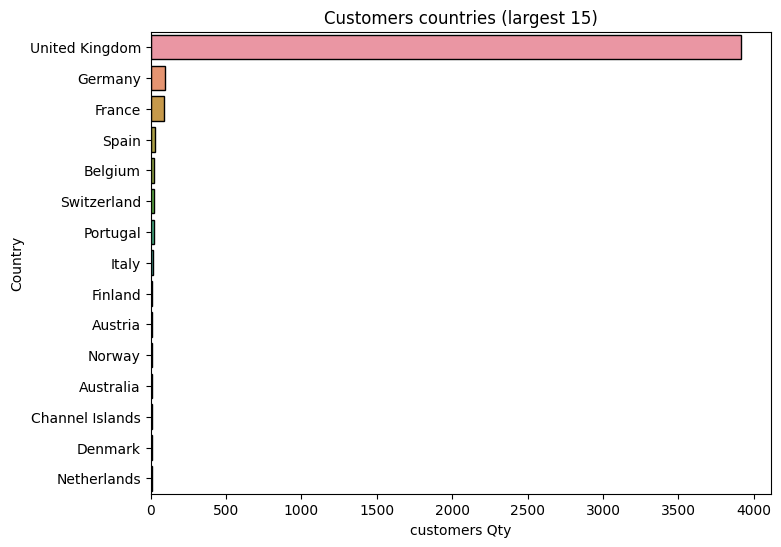

In [186]:
#df = pd.read_csv('data/segm_data_treated.csv', index_col=0)

df = data.copy()
country_df = df.groupby('Country')['CustomerID'].nunique().nlargest(15).sort_values(ascending=False).to_frame()

plt.figure(figsize=(8,6)) #,dpi=200)
sns.barplot(y=country_df.index, x=country_df['CustomerID'], orient='h').set(title='Customers countries (largest 15)', xlabel='customers Qty');


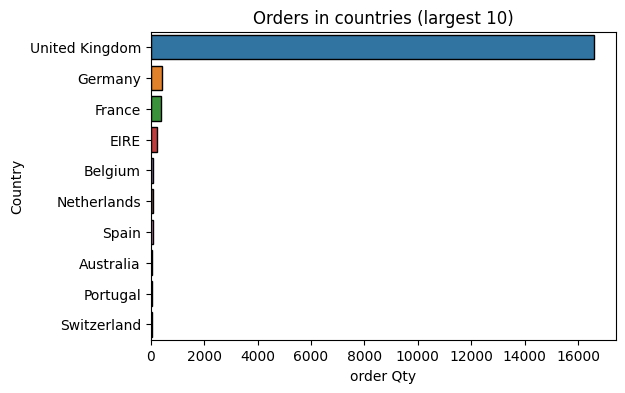

In [187]:
order_df = df.groupby('Country')['InvoiceNo'].nunique().nlargest(10).sort_values(ascending=False).to_frame()

plt.figure(figsize=(6,4)) #,dpi=200)
sns.barplot(y=order_df.index, x=order_df['InvoiceNo'], orient='h').set(title='Orders in countries (largest 10)', xlabel='order Qty');

Let's add the total price of the order to the dataset, let's call it TotalPrice.
The total order price is calculated as:
 
**total price = unit price * (number of goods in order - number of returned goods).**



In [188]:
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])
df['TotalPrice'].describe()

count    391150.000000
mean         21.126404
std          67.823746
min         -81.000000
25%           4.680000
50%          11.700000
75%          19.500000
max        7144.720000
Name: TotalPrice, dtype: float64

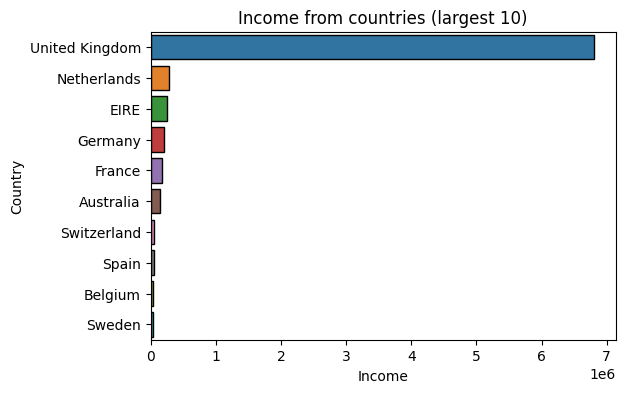

In [189]:
country_df = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).nlargest(10)

plt.figure(figsize=(6,4)) #,dpi=200)
sns.barplot(y=country_df.index, x=country_df.values, orient='h').set(title='Income from countries (largest 10)', xlabel='Income');


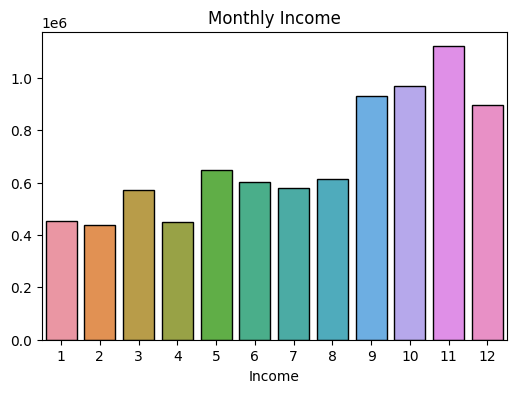

In [190]:
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceWDay'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDay'] = df['InvoiceDate'].dt.day

month_income = df.groupby('InvoiceMonth')['TotalPrice'].sum().sort_values()
plt.figure(figsize=(6,4)) #,dpi=200)
sns.barplot(x=month_income.index, y=month_income.values, orient='v').set(title='Monthly Income', xlabel='Income');

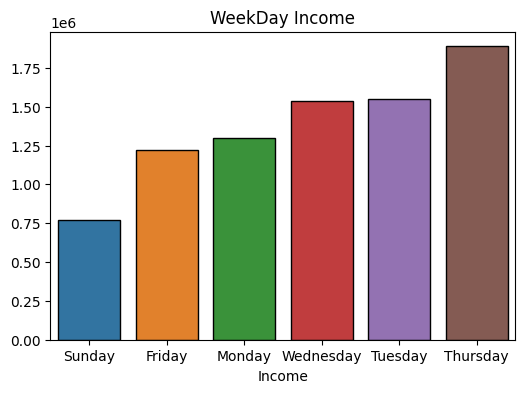

In [191]:
day_income = df.groupby('InvoiceWDay')['TotalPrice'].sum().sort_values(ascending=True)
plt.figure(figsize=(6,4)) #,dpi=200)
sns.barplot(x=day_income.index, y=day_income.values, orient='v').set(title='WeekDay Income', xlabel='Income');

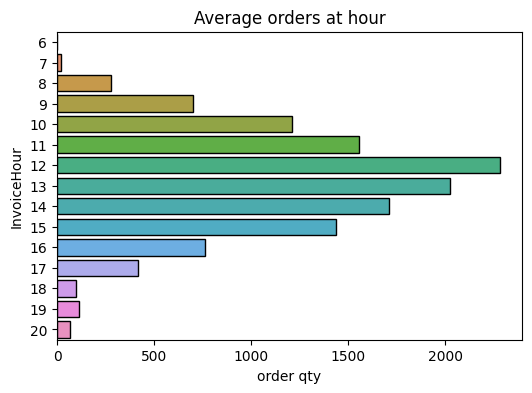

In [192]:
day_hour_df = df.groupby(['InvoiceDay', 'InvoiceHour'])['InvoiceNo'].agg(count='count').reset_index()

hour_df = day_hour_df.groupby('InvoiceHour')['count'].mean().sort_values()

plt.figure(figsize=(6,4)) #,dpi=200)
sns.barplot(y=hour_df.index, x=hour_df.values, orient='h').set(title='Average orders at hour', xlabel='order qty');

RFM - segmentation

The RFM method consists of grouping clients based on the following parameters:
* Recency—recency of the client’s last purchase;
* Frequency - the total number of customer purchases;
* Monetary Value - how much money the client spent.


The essence of RFM analysis is that we divide all customers into groups depending on how long ago they made their last purchase, how often they bought and how large the amount of their orders was.

The task of marketers is to lead the client to the loyal zone.

We can calculate RFM characteristics for each of the clients in our dataset and, based on them, using clustering methods, build similar client segments linked to our data.

To get the RFM table, we need to group the data by client IDs and calculate the following aggregate characteristics:

* Recency for the i-th client is calculated as the difference between the date and time of the last order and the reference point, converted into days:
     $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

     where $t_{ij}$ is the date and time the i-th client made his j-th purchase.

     As a starting point $t_0$ we take a date one day “older” than all our data. This will be December 10, 2011 (in datetime format - '2011-12-10 00:00:00').

* Frequency is calculated as the total number of unique orders made by the i-th client.
* Monetary Value is calculated as the total amount of money that the i-th customer spent on our products (including returns).


In [193]:
t0 = datetime(2011,12,10,00,00,00)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (t0 - np.max(x)).days,
    'InvoiceNo':'nunique', 
    'TotalPrice':'sum'
    }).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice':'Monetary'})

print(rfm.shape)
rfm.head()

(4334, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


In [194]:
print(f"Customers with the last order >200 days ago: {rfm[rfm['Recency']>200].shape[0]}")
print(f"Average orders per period: {rfm['Frequency'].mean().round()}")
print(f"Customer 12360 totally spent: {rfm.loc['12360','Monetary'].round()}")

Customers with the last order >200 days ago: 743
Average orders per period: 4.0
Customer 12360 totally spent: 2302.0


In [195]:
boxes = [px.box(rfm, x=column) for column in rfm.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('data/boxplot_1.html')
fig.show()

There are customers with an abnormally large number of orders (more than 100 pieces), as well as customers whose total order value exceeds £190,000.

Outliers can negatively affect the results of clustering methods that are not robust to them, such as the KMeans algorithm, so I would like to get rid of them. However, we also don’t want to lose a lot of valuable data about clients, so we will limit ourselves to the upper limit of the corresponding quantile at the level of 0.95. Therefore, we will delete the data of those clients whose Frequency parameter or Monetary parameter value is higher than 95% of clients.

In [196]:
m1 = (rfm['Frequency'] > rfm['Frequency'].quantile(0.95))
m2 = (rfm['Monetary'] > rfm['Monetary'].quantile(0.95))
rfm_cleaned = rfm[~(m1 | m2)]

rfm_cleaned.shape

(4044, 3)

In [197]:
boxes = [px.box(rfm_cleaned, x=column) for column in rfm_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('data/boxplot_2.html')
fig.show()

We have finally reached the clustering stage. First, we need to estimate how observations are distributed in feature space. Fortunately, we only have three parameters by which we want to cluster clients, so the data can be visualized in the form of a three-dimensional scatterplot.




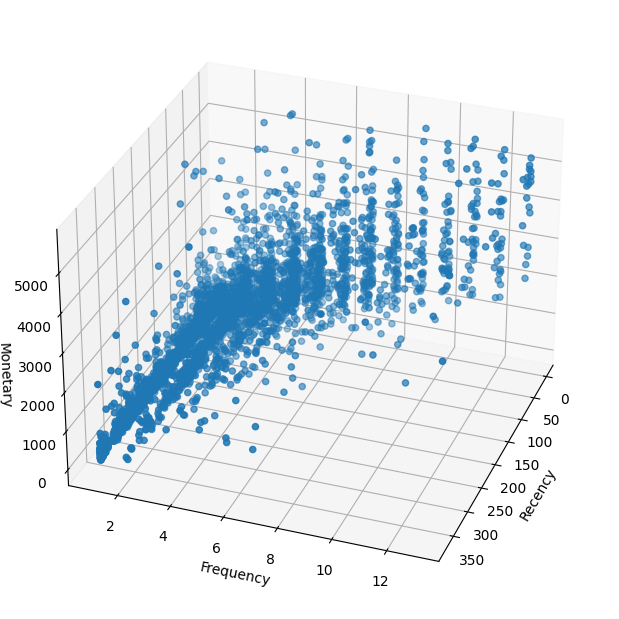

In [198]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

ax.scatter(
    rfm_cleaned['Recency'].to_list(), 
    rfm_cleaned['Frequency'].to_list(),
    rfm_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


It can be seen that there are clients with large values of the Monetary and Frequency parameters - these are probably the best clients who buy most often and bring in the most money. However, based on the total mass of points, it is difficult to say how many clusters we have - rather, it even seems that the space cannot be clustered.

Let's call on dimensionality reduction techniques to help.


Let's start with principal component analysis (PCA). We know that for its stable operation the data needs to be standardized/normalized.


In [199]:
pipeline1 = pipeline.Pipeline([
    ('stsc', preprocessing.StandardScaler()), 
    ('pca', decomposition.PCA(n_components=2))
    ])

rfm_decomp = pipeline1.fit_transform(rfm_cleaned)

print(f"Variance explained by components: {pipeline1[1].explained_variance_ratio_.round(2)}")

Variance explained by components: [0.68 0.24]


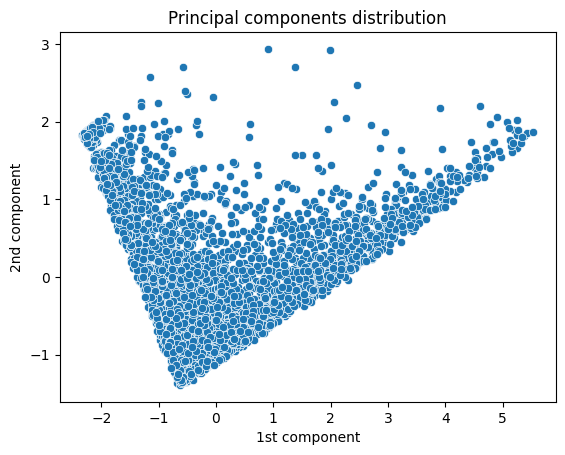

In [200]:
sns.scatterplot(data=rfm_decomp, x=rfm_decomp[:,0], y=rfm_decomp[:,1]).set(title='Principal components distribution', xlabel='1st component', ylabel='2nd component');

Let's try to divide this space of principal components into segments.

In [201]:
# Let's define class Clusterer with several methods helpful for parameters optimization 
class Clusterer():
    def __init__(self, model, range, data):
        self.model = model
        self.data = data
        self.range = range
        self.flex = 0
        self.params = {}
        self.opt_silhouette = 0
        
    def get_params(self):
        if self.model == cluster.KMeans:
            return {'random_state':42,  'n_clusters':self.flex}#'n_init':10,
        elif self.model == mixture.GaussianMixture:
            return {'random_state':42, 'n_components':self.flex}
        elif self.model == cluster.AgglomerativeClustering:
            return {'n_clusters':self.flex}

    def get_scores(self):
        self.params = self.get_params()
        pred = self.model(**self.params).fit_predict(self.data)
        sil_score = metrics.silhouette_score(self.data, pred)
        ch_score = metrics.calinski_harabasz_score(self.data, pred)
        db_score = metrics.davies_bouldin_score(self.data, pred)
        return sil_score, ch_score, db_score
    
    def opt_cluster_qty(self):
        interval = range(*self.range)
        sil = {x:0 for x in interval}
        cal = {x:0 for x in interval}
        dav = {x:0 for x in interval}

        for num in interval:
            self.flex = num
            sil[num], cal[num], dav[num] = self.get_scores()

        f,a = plt.subplots(1,3,figsize=(12,4))
        sns.lineplot(x=interval, y=sil.values(), ax=a[0]).set(title='silhouette score', xlabel='cluster qty');
        sns.lineplot(x=interval, y=cal.values(), ax=a[1]).set(title='calinski_harabasz_score', xlabel='cluster qty');
        sns.lineplot(x=interval, y=dav.values(), ax=a[2]).set(title='davies_bouldin_score', xlabel='cluster qty');
        plt.tight_layout()

        max_silhouette_ind = np.argmax(np.array(list(sil.values())))   
        min_davies_ind = np.argmin(np.array(list(dav.values())))    

        opt_silhouette = (round(list(sil.values())[max_silhouette_ind],3), list(sil.keys())[max_silhouette_ind])
        opt_davies = (round(list(dav.values())[min_davies_ind],3) , list(dav.keys())[min_davies_ind])
        
        self.opt_silhouette = opt_silhouette

        return opt_silhouette, opt_davies
    

### KMeans

Max silhouette_score, clusters: (0.524, 3)


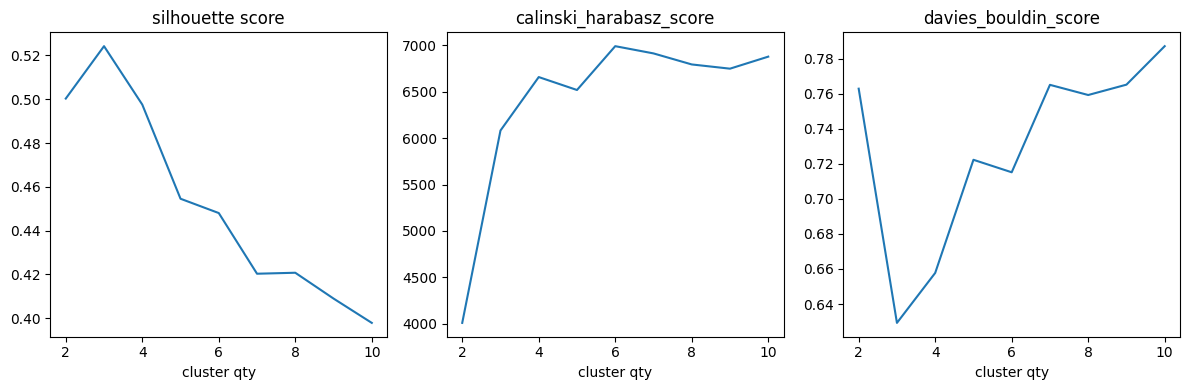

In [202]:
km = Clusterer(cluster.KMeans, [2,11], rfm_decomp)

print(f"Max silhouette_score, clusters: {km.opt_cluster_qty()[0]}")

### EM (GaussianMixture) 

Max silhouette_score, clusters: (0.436, 3)


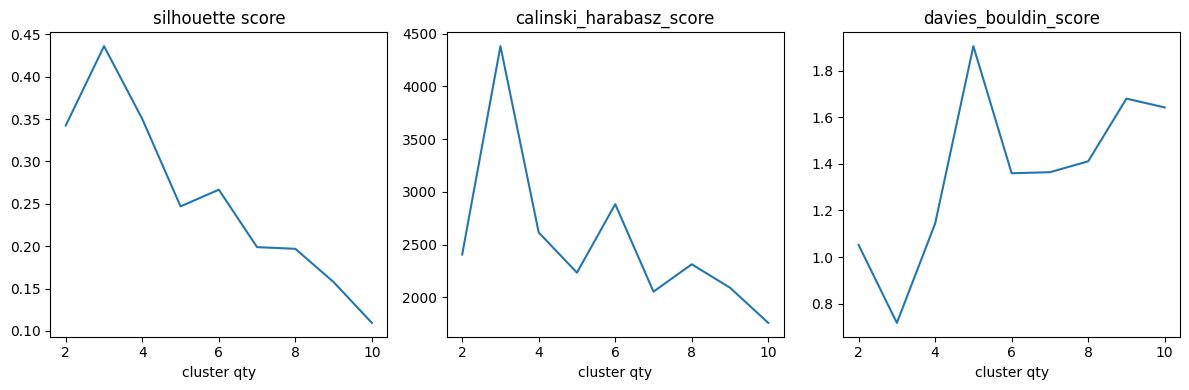

In [203]:
EM = Clusterer(mixture.GaussianMixture, [2,11], rfm_decomp)

print(f"Max silhouette_score, clusters: {EM.opt_cluster_qty()[0]}")

KMeans provided better silhouette score so let's proceed with it



In [204]:
model = cluster.KMeans(n_clusters=3, random_state=42)
pred = model.fit_predict(rfm_decomp)

rfm_clustered = pd.DataFrame(np.hstack([rfm_decomp, pred.reshape(-1,1)]), columns=['component_1', 'component_2', 'Cluster'])
rfm_clustered['Cluster'].value_counts()

Cluster
2.0    2269
0.0     999
1.0     776
Name: count, dtype: int64

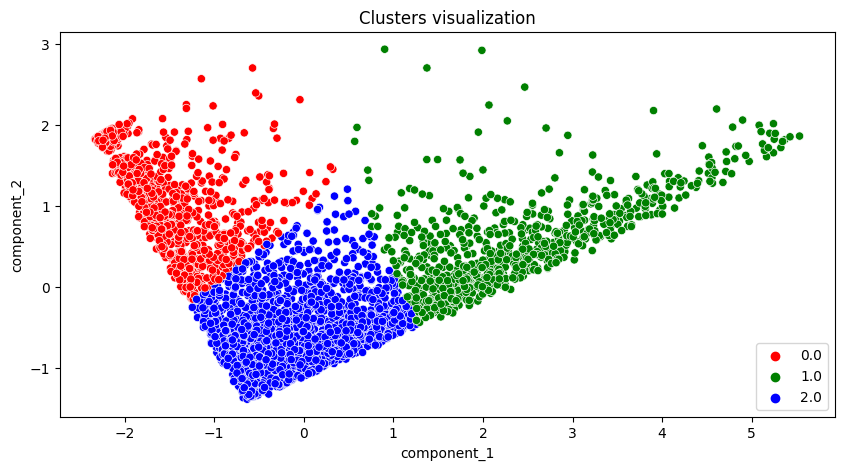

In [205]:
fig = plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=rfm_clustered, 
    x='component_1', 
    y='component_2', 
    hue='Cluster',
    palette=['r','g','b']
).set(title='Clusters visualization');
plt.legend(loc='lower right');

So we have three customer segments. Let's try to create a profile for these segments.

In [206]:
rfm_labeled = rfm_cleaned.copy()
rfm_labeled['Cluster'] = pred
rfm_mean = rfm_labeled.groupby('Cluster').mean()
rfm_mean

,Recency,Frequency,Monetary
Cluster,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


In [207]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Polar diagram drawing

    Args:
        grouped_data (dataframe): data grouped by clusters
        n_clusters (int): quantity of clusters
    """
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    features = grouped_data.columns
    fig = go.Figure()
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, 
            theta=features, 
            fill='toself', 
            name=f'Cluster {i}',
        ))
    fig.update_layout(
        showlegend=True, 
        autosize=False, 
        width=800, 
        height=800,
    )
    
    fig.show()
    

In [208]:
plot_cluster_profile(rfm_mean,3)

* 0 - The cluster corresponds to “lost” customers who bought the least amount of goods, and their last purchase was made a long time ago.
* 1 - The cluster corresponds to “loyal” customers who bring in the most income, make purchases most often, and the duration of their last purchase is the shortest.
* 2 - The cluster corresponds to “intermediate” customers who are active, but do not buy as often or as much as loyal customers. At the same time, these clients are not “lost”.

So, with the help of RFM analysis, we were able to identify three customer segments. However, in marketing it is customary to operate with a large number of them: usually marketers try to create a strategy for at least five to seven client segments in a gradation from “loyal” to “lost” with intermediate categories.

Therefore, having received feedback from marketers, we get back to work, trying to modify the resulting solution.

Previously, we performed clustering in principal component space. Recall that PCA is a linear method for mapping the original feature space to a compressed version of it.

What if you use a nonlinear transformation? For example, the t-SNE dimension reduction algorithm.

In [209]:
pipeline2 = pipeline.Pipeline([
    ('stsc', preprocessing.StandardScaler()), 
    ('pca', manifold.TSNE(perplexity=50, random_state=100))
    ])

rfm_decomp2 = pipeline2.fit_transform(rfm_cleaned)

print(f"KL_divergence value: {round(pipeline2[1].kl_divergence_,2)}")

KL_divergence value: 0.54


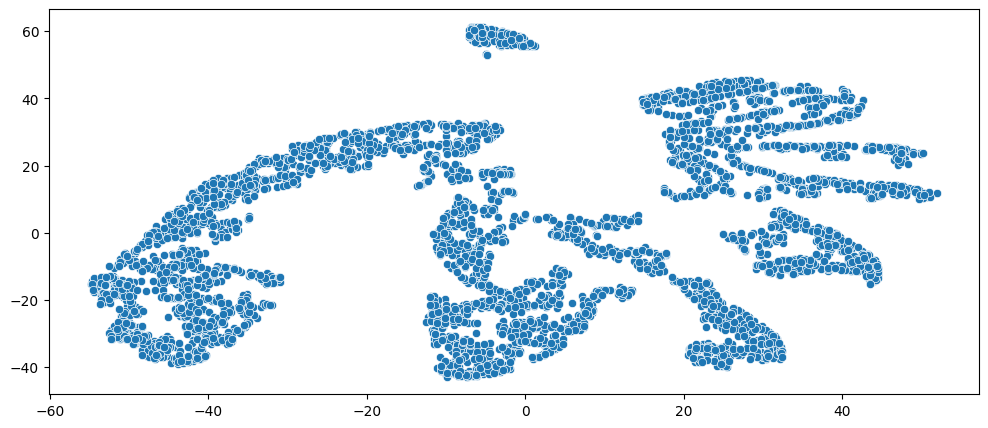

In [210]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=rfm_decomp2[:,0], y=rfm_decomp2[:,1]);

As expected from t-SNE, the algorithm grouped the most similar objects into similar clusters, and these clusters were easy to identify.

Now let's use clustering algorithms to form new customer segments.

### KMeans



Max silhouette_score, clusters: (0.484, 7)


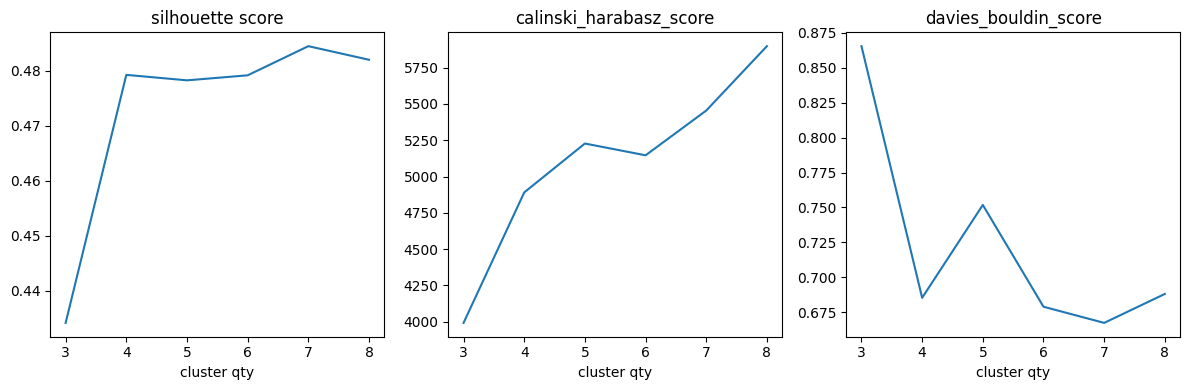

In [211]:
kmeans = Clusterer(cluster.KMeans, [3,9], rfm_decomp2)

print(f"Max silhouette_score, clusters: {kmeans.opt_cluster_qty()[0]}")

### EM (GaussianMixture) 


Max silhouette_score, clusters: (0.469, 4)


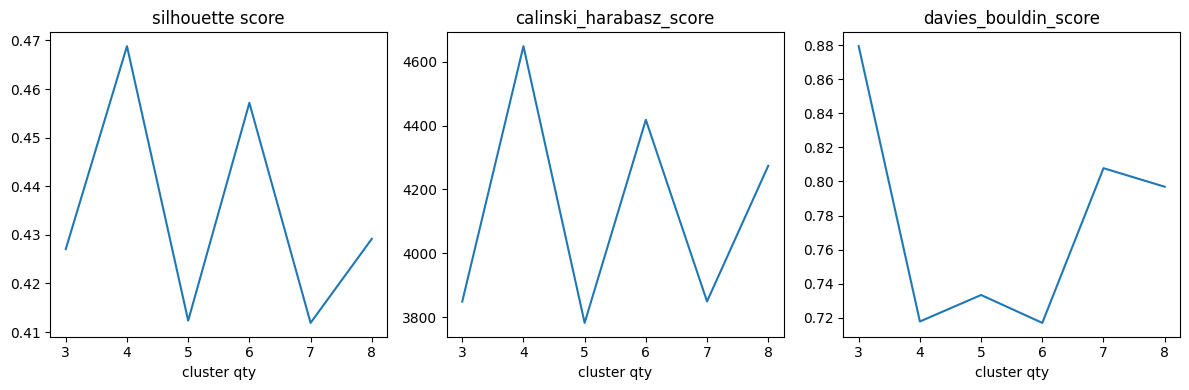

In [212]:
EM = Clusterer(mixture.GaussianMixture, [3,9], rfm_decomp2)

print(f"Max silhouette_score, clusters: {EM.opt_cluster_qty()[0]}")

### AgglomerativeClustering



Max silhouette_score, clusters: (0.479, 8)


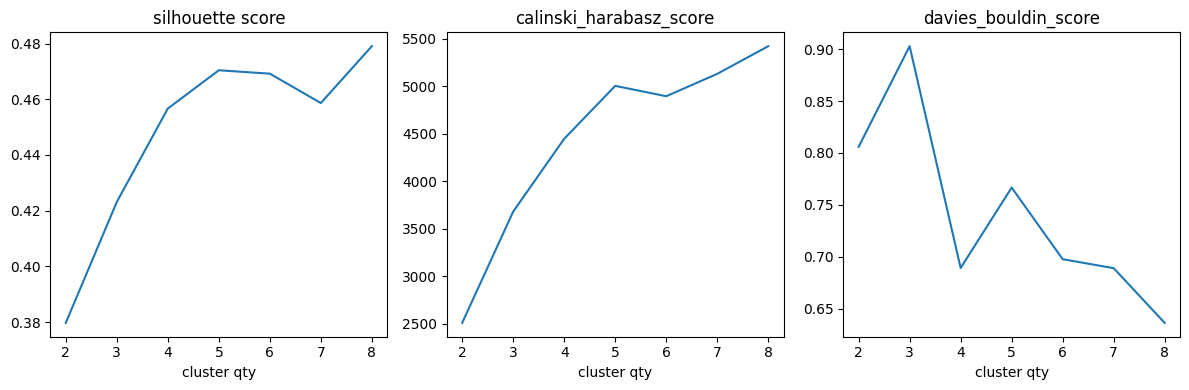

In [213]:
agglom = Clusterer(cluster.AgglomerativeClustering, [2,9], rfm_decomp2)

print(f"Max silhouette_score, clusters: {agglom.opt_cluster_qty()[0]}")

Let's determine the best model: For which the silhouette score is the greatest



In [214]:
cluster_methods = pd.DataFrame({
    'Method': [kmeans.__dict__['model'].__name__, EM.__dict__['model'].__name__, agglom.__dict__['model'].__name__],
    'Max silhouette': [kmeans.opt_silhouette[0], EM.opt_silhouette[0], agglom.opt_silhouette[0]],
    'Opt clusters': [kmeans.opt_silhouette[1], EM.opt_silhouette[1], agglom.opt_silhouette[1]]}
    )

display(cluster_methods)


km = cluster.KMeans(n_clusters=7, random_state=42, n_init=10)
km.fit(rfm_decomp2)

rfm_decomp_df = pd.DataFrame(data=rfm_decomp2,columns=['1','2']) # (np.hstack([rfm_decomp, km.labels_.reshape(-1,1)]), columns=['1','2','cluster'])
rfm_decomp_df['Cluster'] = km.labels_
rfm_decomp_df['Cluster'].value_counts()

,Method,Max silhouette,Opt clusters
0,KMeans,0.484,7
1,GaussianMixture,0.469,4
2,AgglomerativeClustering,0.479,8


Cluster
1    914
4    683
0    656
2    543
5    446
6    405
3    397
Name: count, dtype: int64

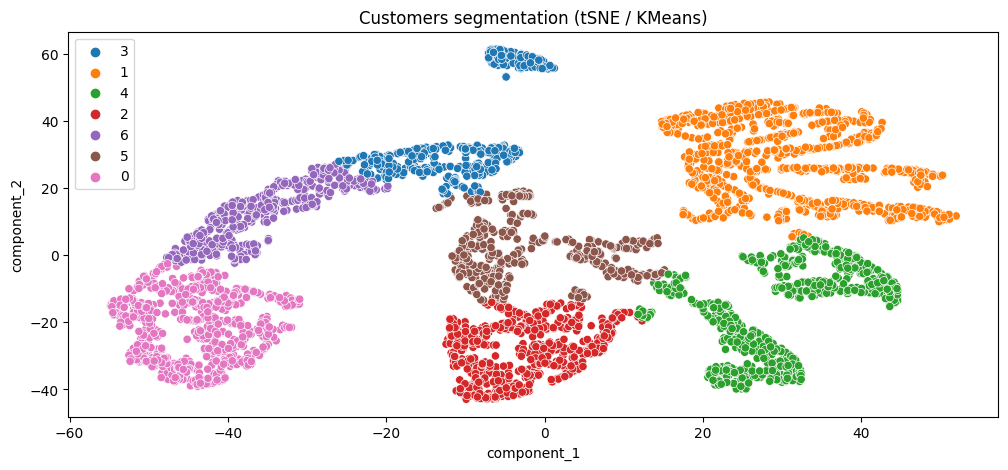

In [221]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_decomp_df, x='1', y='2', hue=km.labels_.astype('str')).set(title='Customers segmentation (tSNE / KMeans)', xlabel='component_1', ylabel='component_2');


So we have 7 customer segments. Let's try to create a profile for these segments.


Дуеэы create a cluster profile

In [216]:
rfm_labeled = rfm_cleaned.copy()
rfm_labeled['Cluster'] = km.labels_

rfm_mean = rfm_labeled.groupby('Cluster').agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).round()
rfm_mean

,Recency,Frequency,Monetary
Cluster,,,
0,46.0,1.0,322.0
1,32.0,7.0,2417.0
2,40.0,2.0,614.0
3,313.0,1.0,261.0
4,40.0,3.0,995.0
5,196.0,2.0,670.0
6,181.0,1.0,273.0


In [217]:
plot_cluster_profile(rfm_mean,7)

* 0 — “newbie” clients who relatively recently made one order for a small amount.
* 1 - “loyal” customers who have the highest income, make purchases more often, and their most recent purchases are the smallest.
* 2 - “stranded” customers who have recently made several orders for a small quantity. Potentially, these clients can be transferred to the “promising” cluster.
* 3 - “lost” customers who bought the least amount of goods, and their last purchase was made about a year ago.
* 4 - “promising” clients who are buyers, but are not active in buying as often and not as much as loyal clients.
* 5 - "riskн" customers who have purchased goods for a small amount several times, but their last purchase was made more than five months ago.
* 6 - “dormant” or “almost lost” customers who made one order for a smaller amount more than five months ago and never returned.

We have built a clustering model for some clients. But how can we predict the segment for clients who were not included in the training set?

Let's reduce the clustering problem to a classification problem. Indeed, we now have true cluster labels, and there are clients that are described by RFM characteristics. Let's train a model that will predict the customer segment based on RFM characteristics.

In [218]:
X = rfm_labeled.drop('Cluster', axis=1) #очищенная RFM-таблица
y = rfm_labeled['Cluster'] #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print(f"TRAIN - {X_train.shape}, TEST - {X_test.shape}")

TRAIN - (3235, 3), TEST - (809, 3)


### RandomForestClassifier



In [219]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

gs = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid,
    #scoring='roc_auc', 
    cv=5, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 
y_pred = gs.predict(X_test)

print(f"BEST hyperparams: {gs.best_params_}")
print(f"BEST score on TRAIN: {gs.best_score_}")
print(f"Accuracy score on TEST: {metrics.accuracy_score(y_test, y_pred).round(3)}")
print(f"{metrics.classification_report(y_test, y_pred)}")

BEST hyperparams: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}
BEST score on TRAIN: 0.988562596599691
Accuracy score on TEST: 0.985
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       140
           1       0.99      0.99      0.99       183
           2       1.00      0.98      0.99       109
           3       0.99      0.97      0.98        71
           4       0.98      0.98      0.98       133
           5       0.97      0.98      0.97        94
           6       0.97      0.97      0.97        79

    accuracy                           0.99       809
   macro avg       0.98      0.98      0.98       809
weighted avg       0.99      0.99      0.99       809



### GradientBoostingClassifier

In [220]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gs = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42), 
    param_grid=param_grid,
    #scoring='roc_auc', 
    cv=5, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 
y_pred = gs.predict(X_test)

print(f"BEST hyperparams: {gs.best_params_}")
print(f"BEST score on TRAIN: {gs.best_score_}")
print(f"Accuracy score on TEST: {metrics.accuracy_score(y_test, y_pred).round(3)}")
print(f"{metrics.classification_report(y_test, y_pred)}")

BEST hyperparams: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
BEST score on TRAIN: 0.9860896445131375
Accuracy score on TEST: 0.983
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       140
           1       0.98      0.98      0.98       183
           2       0.99      0.99      0.99       109
           3       0.99      1.00      0.99        71
           4       0.98      0.96      0.97       133
           5       0.95      0.97      0.96        94
           6       0.99      0.97      0.98        79

    accuracy                           0.98       809
   macro avg       0.98      0.98      0.98       809
weighted avg       0.98      0.98      0.98       809



we dealt with the nonparametricity problem of t-SNE and were able to move from solving a clustering problem to a classification problem. Now we have a model that, based on the client’s RFM characteristics, automatically determines its segment.